In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium.utils.env_checker import check_env
from gymnasium.envs.registration import register
from stable_baselines3 import PPO
from sklearn.model_selection import train_test_split

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.evaluation import evaluate_policy
import wandb
from wandb.integration.sb3 import WandbCallback
from sine_env import SineEnv

In [2]:
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 500_000,
    "env_name": "SineWave-v0",
}

In [3]:
# # METRICS
# run = wandb.init(
#     project="sinewave",
#     notes="v0.1",
#     config=config,
#     sync_tensorboard=True,
#     # monitor_gym=True,
# )

In [4]:
# DATA
df = SineEnv.create_sinewave(frequency=10, count=1000, min=1, max=10)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False) 

/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.show to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.show` for environment variables or `env.get_wrapper_attr('show')` that will search the reminding wrappers.
  logger.warn(


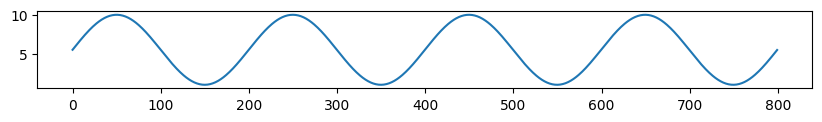

In [5]:
# TRAINING ENV
register(
    id='SineEnv-v0', 
    entry_point='sine_env:SineEnv',
    nondeterministic=False,
    # reward_threshold=
    # autoreset=
)
env = gym.make('SineEnv-v0', df=train_df, lookback=3)
env.show()

In [6]:
# CHECK ENV
check_env(env.unwrapped)
observation, _ = env.reset()
for _ in range(5):
    action = env.action_space.sample()
    observation, reward, _, _, _ = env.step(action)
    print(observation)

[0.         0.02572543 0.02505543]
[0.02572543 0.02505543 0.02439463]
[0.02505543 0.02439463 0.02374295]
[0.02439463 0.02374295 0.02310024]
[0.02374295 0.02310024 0.02246636]


In [7]:
# TRAIN
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./logs")
model.learn(
    total_timesteps=config["total_timesteps"], 
    # callback=WandbCallback()
)
wandb.finish()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51       |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    fps             | 434      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 60.1       |
|    ep_rew_mean          | -10.4      |
| time/                   |            |
|    fps                  | 413        |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01583039 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entr

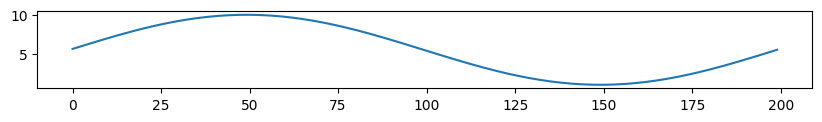

Mean reward: 187.0 +/- 0.00


In [9]:
# TEST
lookback = 3
test_df.reset_index(drop=True, inplace=True)
env = gym.make('SineEnv-v0', df=test_df, lookback=lookback)
obs, _ = env.reset()
# env.show()
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')
